# Cleaning raw data2

In [65]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
xlsx_path = "../input_folder/dataset_2020-2023_RanaK.xlsx"

In [3]:
yrs_int = [2020, 2021, 2022, 2023]
yrs = ["2020", "2021", "2022", "2023"]
dfs = []

def read_raw_data(yr):
    df = pd.read_excel(xlsx_path, sheet_name=yr)
    df.set_index("ID2", drop=False, inplace=True)

    # clean string columns
    for c in ["Gender", "Ward", 'Type of Sample']:
        df[c] = df[c].str.strip().str.title()

    df["Type of Sample"] = df["Type of Sample"].str.replace("Stool Cluture", "Stool Culture")
    df["Type of Sample"] = df["Type of Sample"].str.replace("Peritonial Fluid", "Peritoneal Fluid")
    
    for c in ["Organism"]:
        df[c] = df[c].str.strip().str.capitalize()

    to_replace = {
        'Acinetobacter baumanii': 'Acinetobacter baumannii',
        'Aeromonas hydrophilia': 'Aeromonas hydrophila',
        'Bacteroides species': 'Bacteroides spp',
        'Enterobacteriacae': 'Enterobacteriaceae',
        'Flaviobacterium spp': 'Flavobacterium spp',
        'Klebsiella spp.': 'Klebsiella spp',
        'Micrococcus species': 'Micrococcus spp',
        'Providencia  stuartii': 'Providencia stuartii',
        'Streptococcus group c': 'Streptococcus Group C'
    }
    
    df["Organism"] = df["Organism"].replace(to_replace)

    for c in ["Type of AMR"]:
        df[c] = df[c].str.strip()
    #df[col] = df[col].method(value)
    df["Type of AMR"] = df["Type of AMR"].replace({"": np.nan, "-": np.nan})
    
    df["Year"] = int(yr)
    # df["Year"] = pd.to_datetime(yr, format="%Y")
    
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], format='%d/%m/%Y')
    reference_date = pd.Timestamp('2025-02-01')
    df['Age'] = (reference_date - df['Date of Birth']).dt.days // 365

    df['Date of Request'] = pd.to_datetime(df['Date of Request'], format='%d/%m/%Y')
    
    return df

    
for yr in yrs:
    sdf = read_raw_data(yr)
    dfs.append(sdf)

df = pd.concat(dfs)
df.sort_values("Year", inplace=True)


Columns: 

In [6]:
df.columns.tolist()

['ID',
 'ID2',
 'Gender',
 'Date of Birth',
 'Age',
 'Ward',
 'Type of Sample',
 'Date of Request',
 'Organism',
 'Type of AMR',
 'Year']

Cleaning data, problems from raw data:

- Gender: `['Male', 'Female', 'Male ', 'male ']`
- Date of Birth
- Age

Dates, I'm assuming it follows the format `%d/%m/%Y`, and I recalculate age too.

## How many entries per year?

In [41]:
def count_entries(col):
    count = []

    cc = df[col].unique()
    for c in cc:
        z1 = df.loc[df[col] == c, :].index.unique().shape[0]
        count.append(z1)
    
    d = pd.DataFrame([cc, count, cc]).T
    d.columns = [col, "Count", "Color"]
    d["Color"] = d["Color"].astype(str)

    d.sort_values("Count", inplace=True)
    return d

# count_entries("Year")

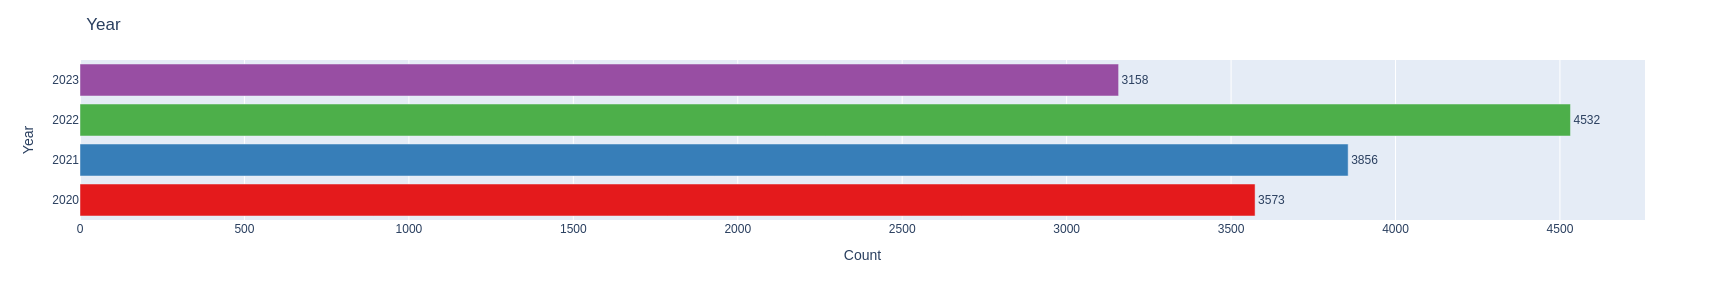

In [42]:
# a = df["Year"].value_counts()
# a = a[[2020, 2021, 2022, 2023]].sort_index()  # optional: sort by year
# plot_df = a.reset_index()
# plot_df.columns = ['Year', 'Count']

# plot_df["Color"] = plot_df["Year"].astype(str)  # or just str values

plot_df = count_entries("Year")

fig = px.bar(
    plot_df,
    x='Count',
    y='Year',
    orientation='h',
    text='Count',
    color='Color',  # use the custom color mapping
    color_discrete_map={
        '2020': px.colors.qualitative.Set1[0],
        '2021': px.colors.qualitative.Set1[1],
        '2022': px.colors.qualitative.Set1[2],
        '2023': px.colors.qualitative.Set1[3],
    }
)

fig.update_layout(
    title='Year',
    xaxis=dict(range=[0, plot_df['Count'].max() * 1.05]),
    yaxis=dict(categoryorder='array', categoryarray=plot_df['Year'][::-1]),
    height=300,
    showlegend=False  # now this actually works
)

fig.update_traces(textposition='outside')
fig.show()

## Gender

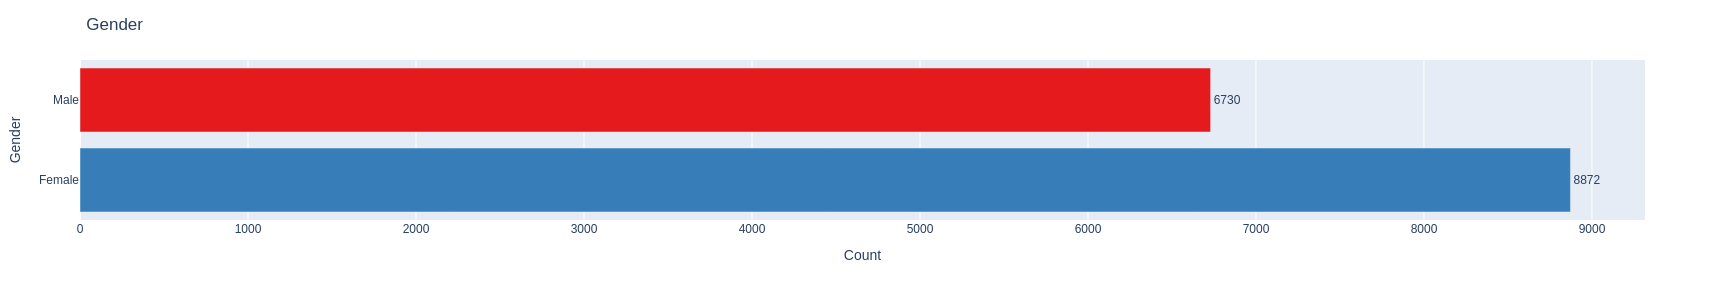

In [43]:
# Prepare data
# a = df['Gender'].value_counts(ascending=True)
# plot_df = a.reset_index()
# plot_df.columns = ['Gender', 'Count']

plot_df = count_entries("Gender")

# Create Plotly Express horizontal bar chart
fig = px.bar(
    plot_df,
    x='Count',
    y='Gender',
    orientation='h',
    text='Count',
    color='Gender',  # optional: different color per gender
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Tweak layout and labels
fig.update_layout(
    title='Gender',
    xaxis=dict(range=[0, plot_df['Count'].max() * 1.05]),
    showlegend=False,
    height=300
)

fig.update_traces(textposition='outside')
fig.show()

## Date of Birth

In [44]:
eldest = df["Date of Birth"].min()
youngest = df["Date of Birth"].max()

print(f"""Eldest: {eldest},
Youngest: {youngest}""")

Eldest: 1914-01-01 17:18:35,
Youngest: 2023-12-24 10:15:28


## Age

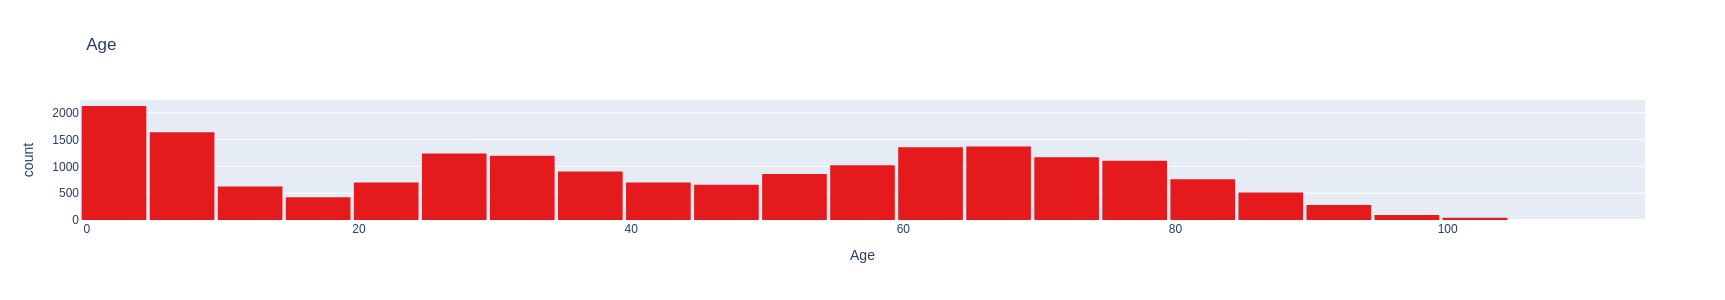

In [45]:
fig = px.histogram(
    df,
    x="Age",
    nbins=30,
    title="Age",
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(
    bargap=0.05,  # optional: small gap between bars
    height=300
)

fig.show()

## Date of Request

In [46]:
for yr in yrs:
    yr = int(yr)
    earliest = df.loc[df["Year"] == yr, :]["Date of Request"].min()
    latest = df.loc[df["Year"] == yr, :]["Date of Request"].max()
    
    
    print(f"""Year: {yr},
    Earliest: {earliest},
    Latest: {latest}""")
    print()

Year: 2020,
    Earliest: 2020-01-01 00:00:00,
    Latest: 2020-12-01 00:00:00

Year: 2021,
    Earliest: 2021-01-01 00:00:00,
    Latest: 2021-12-01 00:00:00

Year: 2022,
    Earliest: 2022-01-01 00:00:00,
    Latest: 2022-12-01 00:00:00

Year: 2023,
    Earliest: 2023-01-01 00:00:00,
    Latest: 2023-12-31 09:14:28



Something weird going on with the date:

- Most of the years, sample collection ended on 1st Dec?
- Earliest sample on 2023 is on 1st June?

## Ward

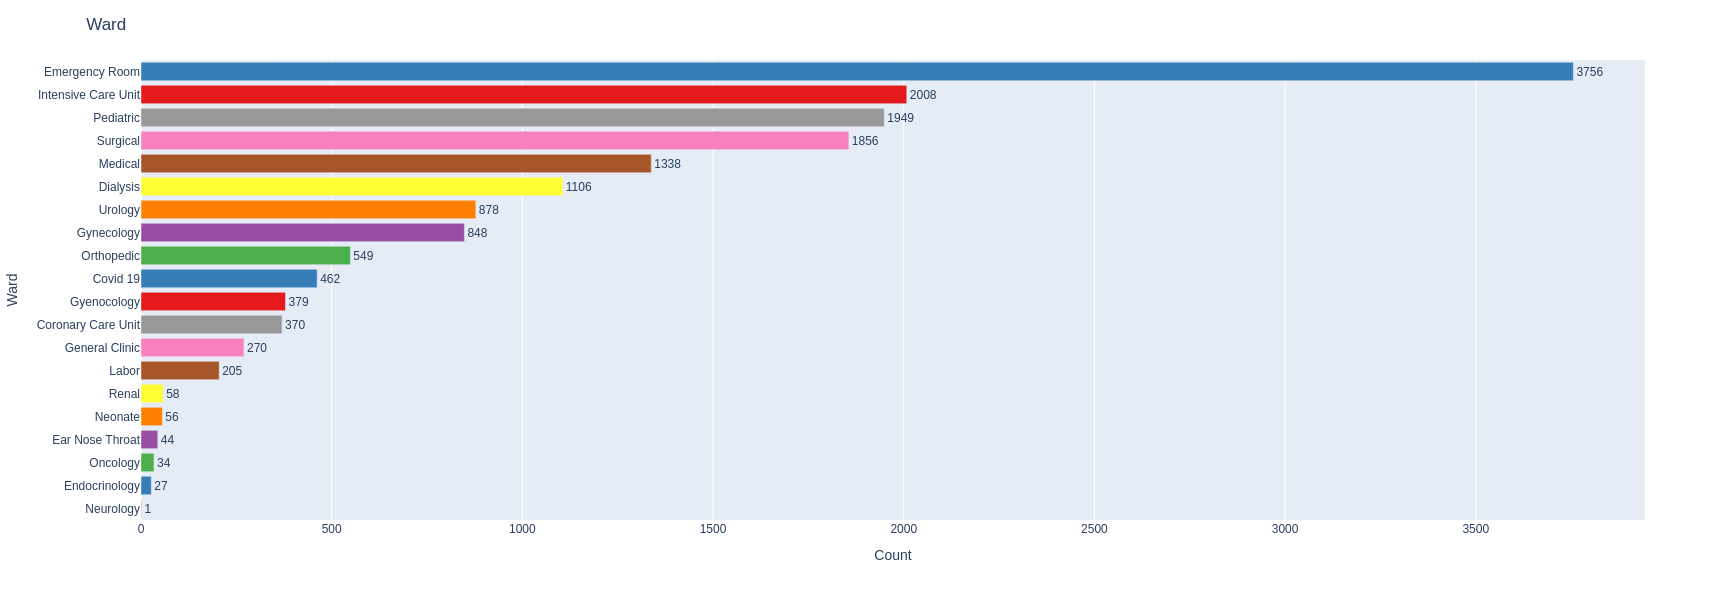

In [47]:
# Prepare data
# a = df['Ward'].value_counts(ascending=True)
# plot_df = a.reset_index()
# plot_df.columns = ['Ward', 'Count']

plot_df = count_entries("Ward")

fig = px.bar(
    plot_df,
    x='Count',
    y='Ward',
    orientation='h',
    text='Count',
    color='Ward',
    color_discrete_sequence=px.colors.qualitative.Set1,
)

fig.update_layout(
    title='Ward',
    xaxis=dict(range=[0, plot_df['Count'].max() * 1.05]),
    yaxis=dict(
        categoryorder='array',
        categoryarray=plot_df['Ward'].tolist()  # maintain ascending order
    ),
    showlegend=False,
    height=600
)

fig.update_traces(textposition='outside')
fig.show()

## Type of Sample

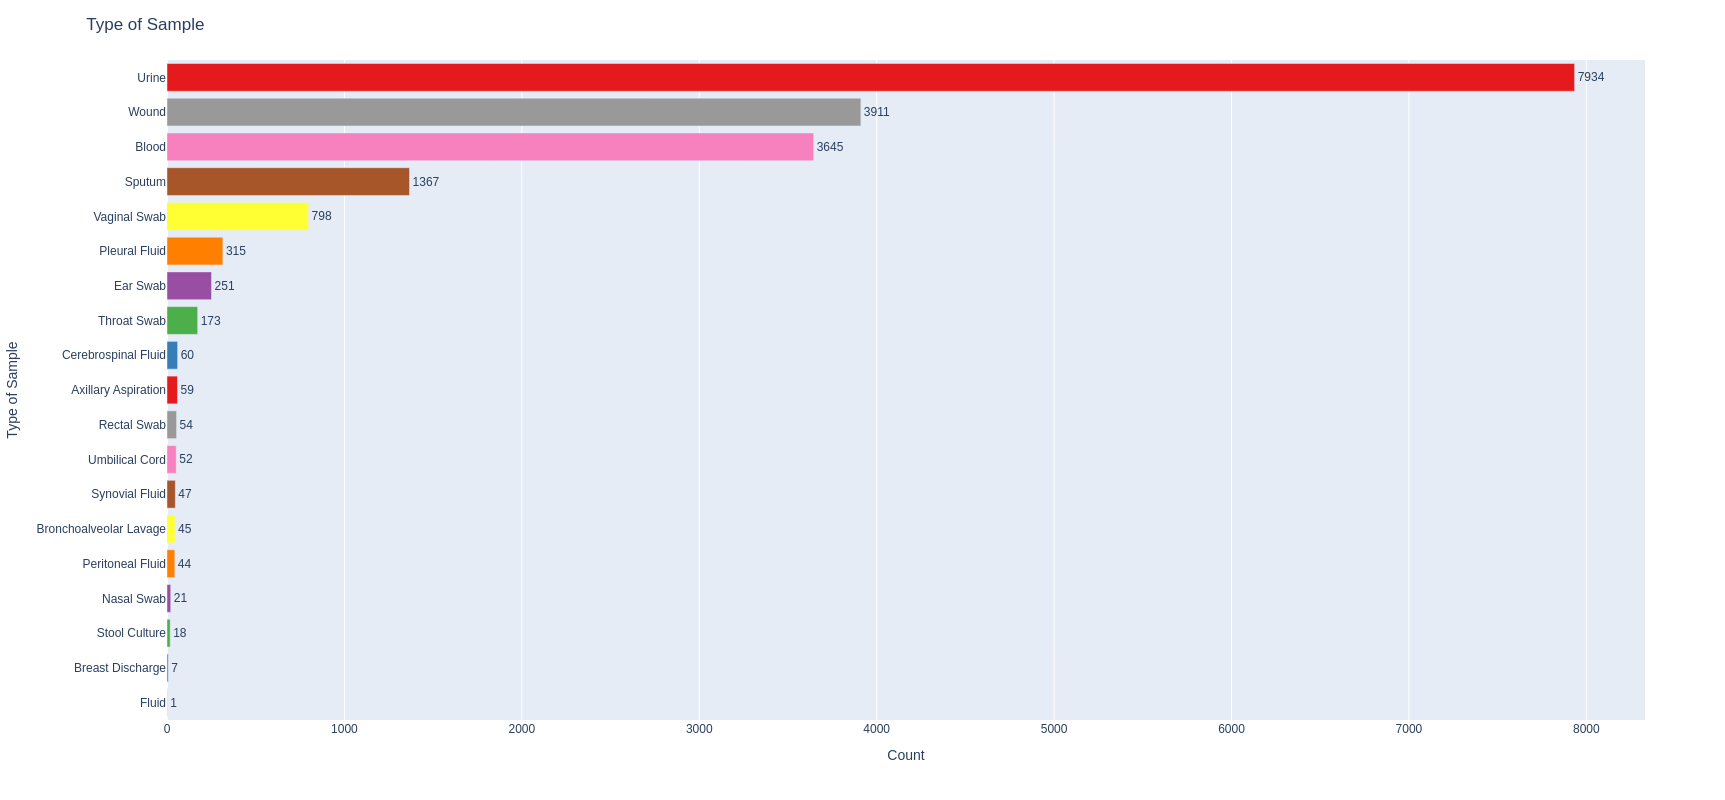

In [48]:
# Prepare data
a = df['Type of Sample'].value_counts(ascending=True)
plot_df = a.reset_index()
plot_df.columns = ['Type of Sample', 'Count']

# Plotly Express bar plot
fig = px.bar(
    plot_df,
    x='Count',
    y='Type of Sample',
    orientation='h',
    text='Count',
    color='Type of Sample',
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Layout tweaks
fig.update_layout(
    title='Type of Sample',
    xaxis=dict(range=[0, plot_df['Count'].max() * 1.05]),
    yaxis=dict(
        categoryorder='array',
        categoryarray=plot_df['Type of Sample'].tolist()
    ),
    showlegend=False,
    height=800
)

# Show count outside bars
fig.update_traces(textposition='outside')
fig.show()

## Organism

In [49]:
org = df['Organism'].value_counts().to_dict()
org = dict(sorted(org.items()))
all_organisms = list(org.keys())

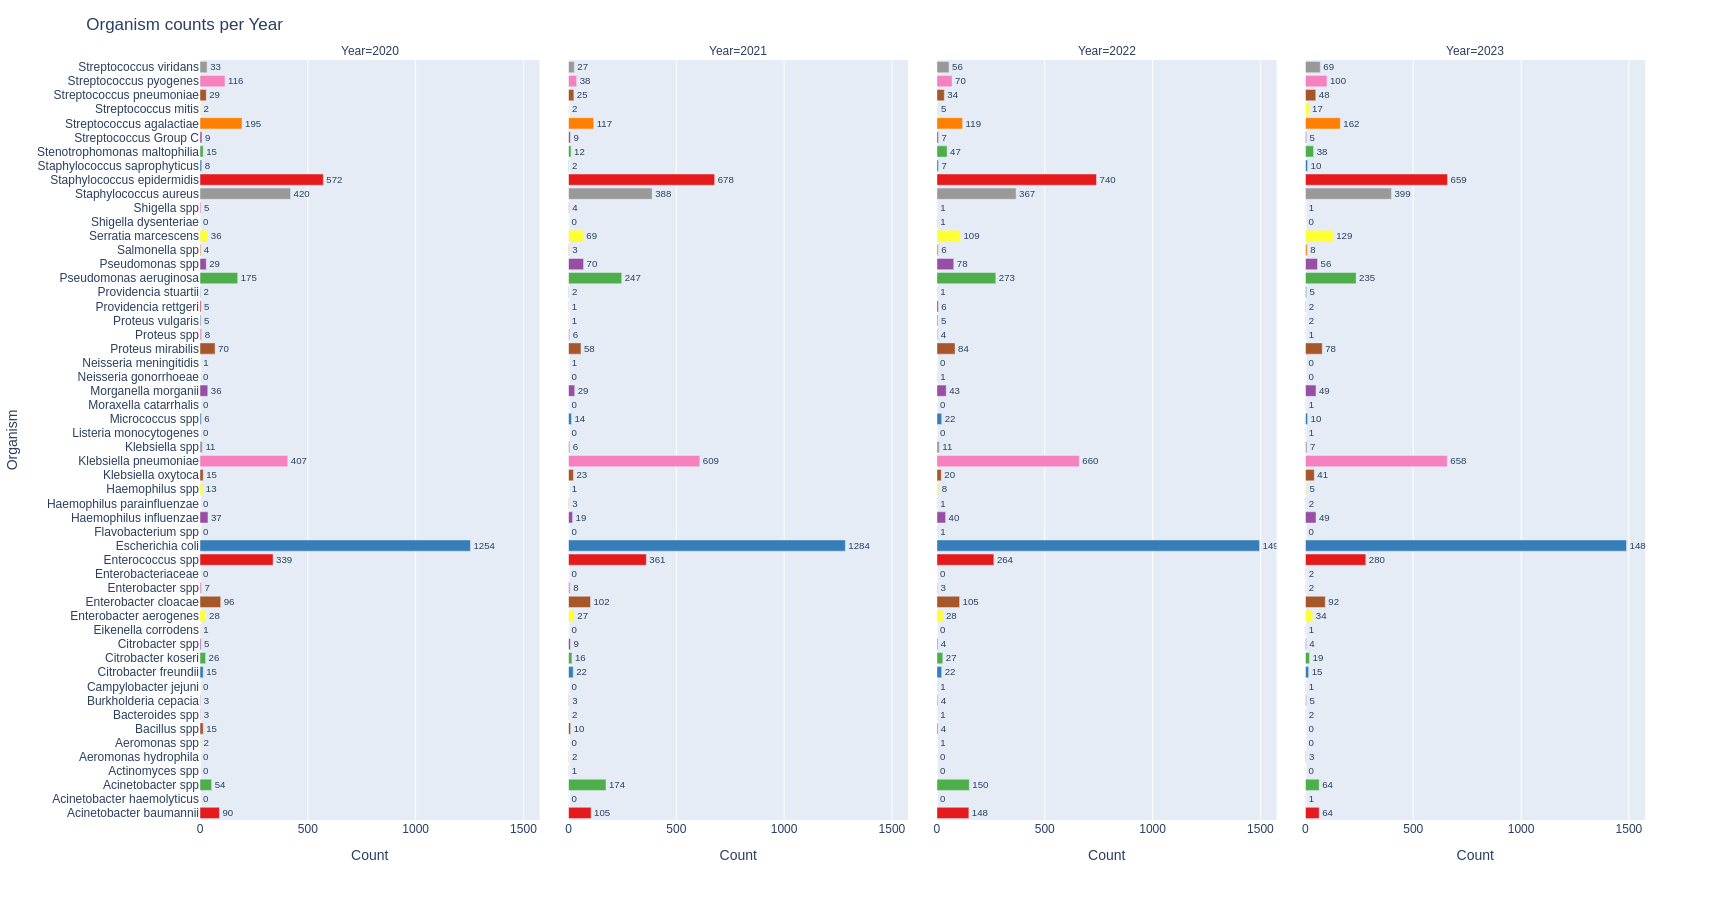

In [50]:
# Build a new DataFrame for plotting
plot_df = []

for yr in yrs:
    yr = int(yr)
    subset = df[df["Year"] == yr].value_counts("Organism")
    subset = subset.reindex(all_organisms, fill_value=0)
    subset = subset.reset_index()
    subset.columns = ["Organism", "Count"]
    subset["Year"] = yr
    plot_df.append(subset)

plot_df = pd.concat(plot_df, ignore_index=True)

# Create faceted bar plot
fig = px.bar(
    plot_df,
    x="Count",
    y="Organism",
    facet_col="Year",
    orientation="h",
    color="Organism",
    text="Count",
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Customize layout
fig.update_layout(
    height=900,
    title="Organism counts per Year",
    showlegend=False
)

fig.update_traces(textposition='outside')

# Ensure consistent y-axis order across facets
fig.update_yaxes(categoryorder='array', categoryarray=all_organisms)

fig.show()

## Type of AMR

In [51]:
amrs = df['Type of AMR'].value_counts().to_dict()
amrs = dict(sorted(amrs.items()))
all_amrs = list(amrs.keys())

Types of AMR:

In [52]:
all_amrs

['AMP-RHI',
 'CR-AB',
 'CR-PA',
 'CRE',
 'CRE CP Producer',
 'ESBL-EC',
 'ESBL-KP',
 'MAC-RSP',
 'MAC-RSPN',
 'MRSA',
 'MRSE',
 'PEN-R',
 'VRE']

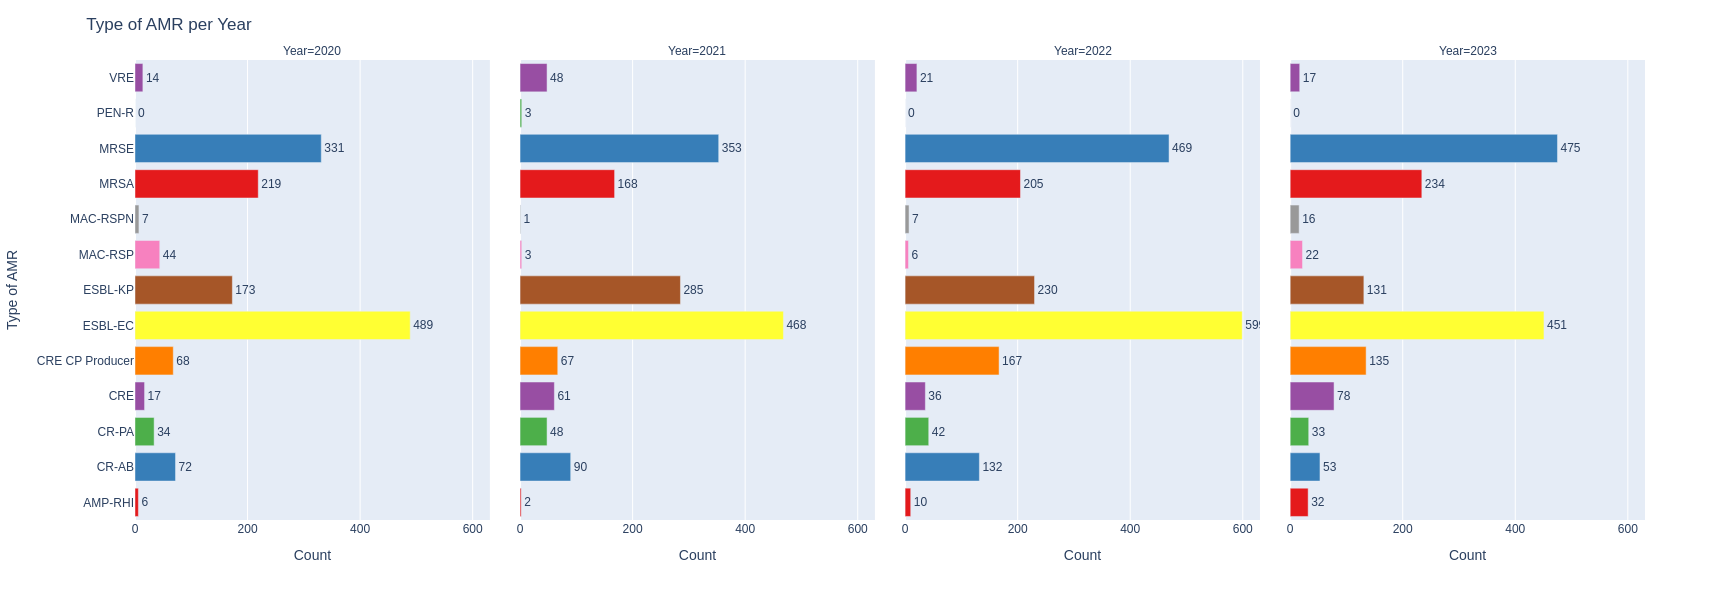

In [53]:
plot_df = []

for yr in yrs:
    yr = int(yr)
    subset = df[df["Year"] == yr].value_counts("Type of AMR")
    subset = subset.reindex(all_amrs, fill_value=0).reset_index()
    subset.columns = ["Type of AMR", "Count"]
    subset["Year"] = yr
    plot_df.append(subset)

plot_df = pd.concat(plot_df, ignore_index=True)

# Plotly Express faceted bar chart
fig = px.bar(
    plot_df,
    x="Count",
    y="Type of AMR",
    facet_col="Year",
    orientation="h",
    color="Type of AMR",
    text="Count",
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Layout adjustments
fig.update_layout(
    height=600,
    title="Type of AMR per Year",
    showlegend=False
)

# Value labels outside bars
fig.update_traces(textposition='outside')

# Consistent y-axis category order
fig.update_yaxes(categoryorder='array', categoryarray=all_amrs)

fig.show()

# QnA

1. What is the Number of samples per year?

In [54]:
df["Year"].value_counts()

Year
2022    5085
2023    4925
2021    4590
2020    4202
Name: count, dtype: int64

2. Which organism is the most frequently isolated across all years?

In [55]:
pd.DataFrame(df["Organism"].value_counts())

,count
Organism,
Escherichia coli,5523
Staphylococcus epidermidis,2649
Klebsiella pneumoniae,2334
Staphylococcus aureus,1574
Enterococcus spp,1244
Pseudomonas aeruginosa,930
Streptococcus agalactiae,593
Acinetobacter spp,442
Acinetobacter baumannii,407


3. What are the most common organisms isolated from the group of samples?

In [56]:
# Get list of sample types
tos = df['Type of Sample'].value_counts(ascending=False).index.tolist()

# Prepare dropdown
dropdown = widgets.Dropdown(
    options=tos,
    value=tos[0],
    description='Sample:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Output widget for plot
out = widgets.Output()

def plot_sample_type(t):
    sdf = df[df["Type of Sample"] == t]
    counts = sdf["Organism"].value_counts(ascending=True)

    if len(counts) > 10:
        top_counts = counts.iloc[-10:]
        original_index = top_counts.index.tolist()
        others_sum = counts.iloc[:-10].sum()
        top_counts["Others"] = others_sum
        final_index = ["Others"] + original_index
        top_counts = top_counts.loc[final_index]
    else:
        top_counts = counts

    plot_df = pd.DataFrame({
        "Organism": top_counts.index,
        "Count": top_counts.values
    })

    fig = px.bar(
        plot_df,
        x="Count",
        y="Organism",
        orientation="h",
        color="Organism",
        text="Count",
        title=f"Top Organisms Isolated from {t}",
        color_discrete_sequence=px.colors.qualitative.Set1
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(showlegend=False, height=400)

    return fig

# Define callback
def update_plot(change):
    with out:
        clear_output(wait=True)
        fig = plot_sample_type(change["new"])
        fig.show()

# Observe dropdown changes
dropdown.observe(update_plot, names="value")

# Initial display
display(dropdown)
with out:
    fig = plot_sample_type(tos[0])
    fig.show()

display(out)

Dropdown(description='Sample:', layout=Layout(width='50%'), options=('Urine', 'Wound', 'Blood', 'Sputum', 'Vag…

Output()

4. What is the percentage of AMR from all the samples?

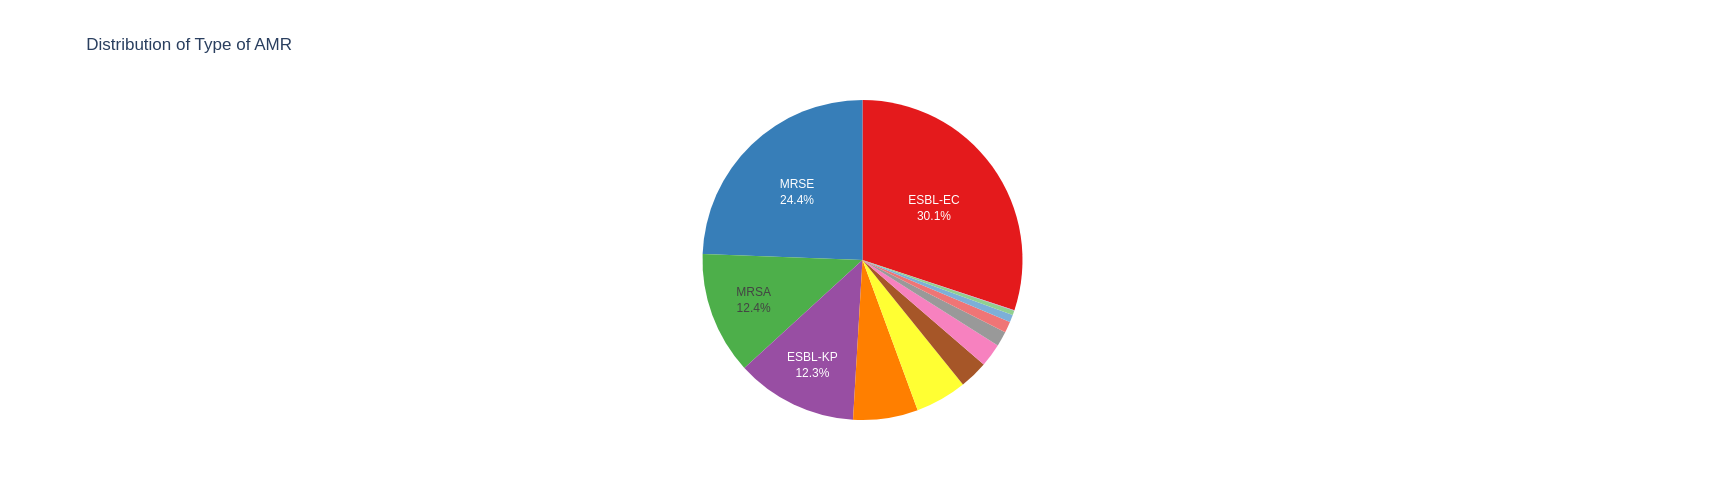

In [57]:
# Count occurrences
counts = df["Type of AMR"].value_counts()

# Top 4 categories
top_4_indices = counts.nlargest(4).index

# Prepare a DataFrame for plotting
plot_df = counts.reset_index()
plot_df.columns = ["Type of AMR", "Count"]

# Calculate percentages
plot_df["Percent"] = plot_df["Count"] / plot_df["Count"].sum() * 100

# Blank out the labels for slices not in top 4
plot_df["Label"] = plot_df.apply(
    lambda row: f"{row['Type of AMR']}<br>{row['Percent']:.1f}%" if row['Type of AMR'] in top_4_indices and row['Percent'] > 5 else "",
    axis=1
)

# Create Plotly pie chart
fig = px.pie(
    plot_df,
    names="Type of AMR",
    values="Count",
    color_discrete_sequence=px.colors.qualitative.Set1,
    title="Distribution of Type of AMR",
    hover_data=["Count", "Percent"],
)

# Use custom text labels (only for top 4)
fig.update_traces(text=plot_df["Label"], textinfo="text", hovertemplate="%{label}<br>Count: %{value}<br>Percent: %{percent}")

# Make the pie circular
fig.update_layout(height=500, width=500, showlegend=False)

fig.show()

5. Which ward/clinic reports the highest rate of antimicrobial resistance?

In [58]:
amr = {}

for w in df["Ward"].unique():
    a = df.loc[df["Ward"] == w, :].value_counts("Type of AMR")
    amr[w] = a

amr = pd.DataFrame.from_dict(amr, orient="index")
amr["SUM"] = amr.sum(axis="columns")
amr.sort_values("SUM", ascending = False)

,ESBL-EC,MRSE,MRSA,ESBL-KP,CR-AB,CRE,AMP-RHI,CR-PA,MAC-RSP,CRE CP Producer,MAC-RSPN,VRE,PEN-R,SUM
Intensive Care Unit,146.0,328.0,126.0,133.0,147.0,78.0,1.0,52.0,4.0,183.0,5.0,26.0,1.0,1230.0
Emergency Room,545.0,197.0,171.0,145.0,15.0,20.0,17.0,20.0,18.0,42.0,8.0,6.0,NaN,1204.0
Surgical,255.0,229.0,129.0,96.0,55.0,27.0,9.0,21.0,19.0,71.0,5.0,26.0,NaN,942.0
Pediatric,255.0,232.0,90.0,79.0,3.0,7.0,2.0,6.0,11.0,20.0,3.0,3.0,NaN,711.0
Medical,207.0,113.0,53.0,80.0,16.0,23.0,10.0,24.0,14.0,37.0,4.0,13.0,NaN,594.0
Dialysis,76.0,254.0,75.0,49.0,1.0,5.0,NaN,2.0,NaN,20.0,NaN,13.0,NaN,495.0
Urology,164.0,22.0,21.0,51.0,2.0,5.0,NaN,7.0,NaN,19.0,NaN,4.0,NaN,295.0
Orthopedic,49.0,57.0,48.0,31.0,15.0,8.0,1.0,9.0,4.0,20.0,1.0,4.0,NaN,247.0
Gynecology,105.0,39.0,29.0,50.0,1.0,6.0,NaN,NaN,NaN,2.0,NaN,1.0,2.0,235.0
Covid 19,47.0,28.0,19.0,28.0,85.0,2.0,1.0,7.0,2.0,7.0,1.0,2.0,NaN,229.0


6. Time series analysis for the AMR organisms by month?

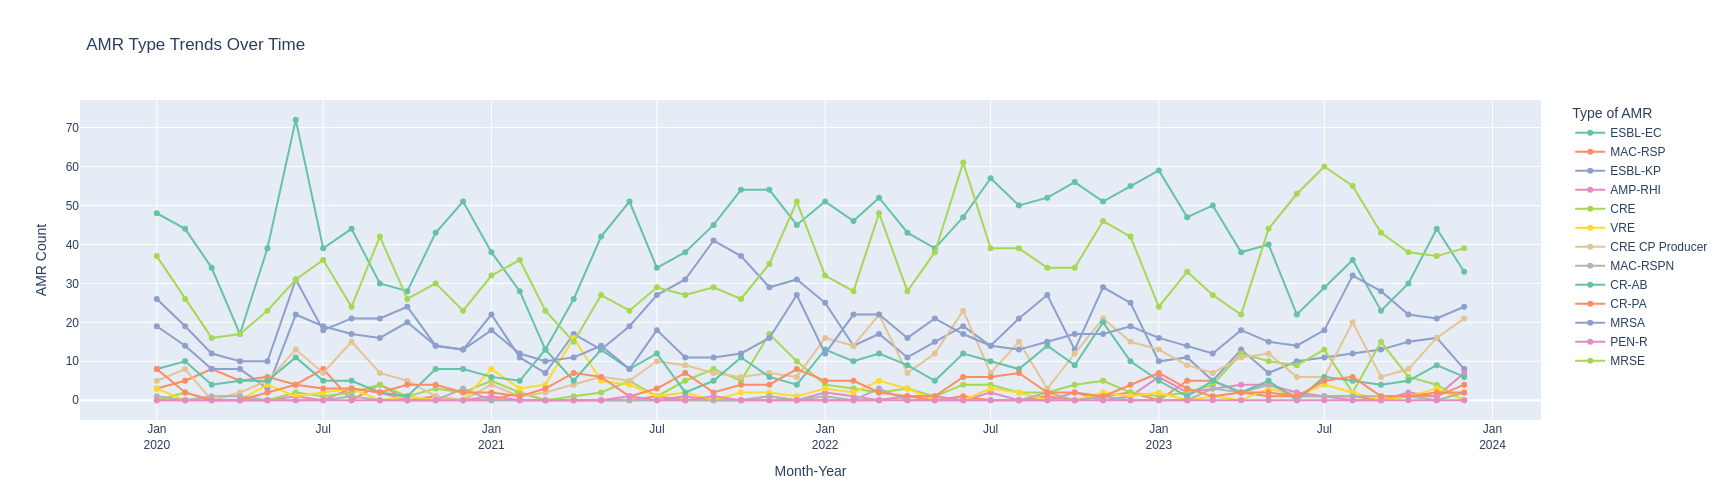

In [59]:
yms = []
for y in range(2020, 2024):
    for m in range(1, 13):
        yms.append(f"{m}-{y}")

# Prepare dataframe
df2 = df.copy()
df2["Month-Year"] = df2["Date of Request"].dt.month.astype(str) + "-" + df2["Date of Request"].dt.year.astype(str)

# Count AMR types per month-year
ts = {}
for my in yms:
    a = df2[df2["Month-Year"] == my]["Type of AMR"].value_counts()
    ts[my] = a

ts = pd.DataFrame.from_dict(ts, orient="index").fillna(0)

# Prepare for plotting
ts = ts.reset_index().melt(id_vars="index", var_name="AMR Type", value_name="Count")
ts = ts.rename(columns={"index": "Month-Year"})

# Optional: sort Month-Year chronologically using datetime
ts["Month-Year"] = pd.to_datetime(ts["Month-Year"], format="%m-%Y")
ts = ts.sort_values("Month-Year")

# Plot with Plotly Express
fig = px.line(
    ts,
    x="Month-Year",
    y="Count",
    color="AMR Type",
    markers=True,
    title="AMR Type Trends Over Time",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    xaxis_title="Month-Year",
    yaxis_title="AMR Count",
    legend_title="Type of AMR",
    xaxis_tickformat="%b\n%Y",
    hovermode="x unified",
    height=500
)

fig.show()

7. Is there a correlation between patient age and Type of AMR Infections?

8. What percentage of E. coli isolates are ESBL-positive?

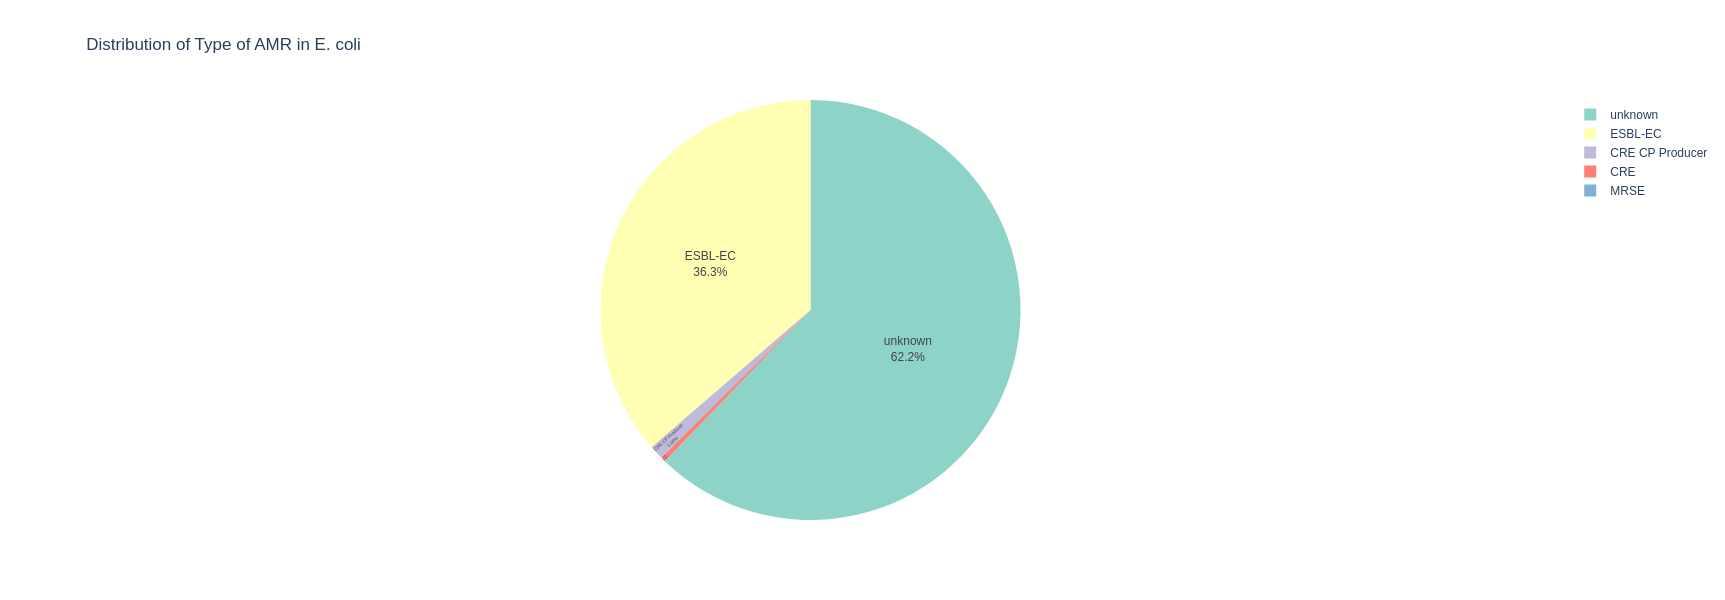

In [60]:
ecoli = df[df["Organism"] == "Escherichia coli"].copy()
ecoli["Type of AMR"] = ecoli["Type of AMR"].fillna("unknown")

counts = ecoli["Type of AMR"].value_counts().reset_index()
counts.columns = ["Type of AMR", "Count"]

# Plotly pie chart
fig = px.pie(
    counts,
    names="Type of AMR",
    values="Count",
    title="Distribution of Type of AMR in E. coli",
    color_discrete_sequence=px.colors.qualitative.Set3,
    hole=0  # full pie chart, set to 0.3 for donut
)

# Add percentage labels
fig.update_traces(textinfo="percent+label", textposition="inside")

fig.update_layout(
    height=600,
    showlegend=True
)

fig.show()

9. What percentage of Klebsiella pneumoniae isolates are ESBL-positive?

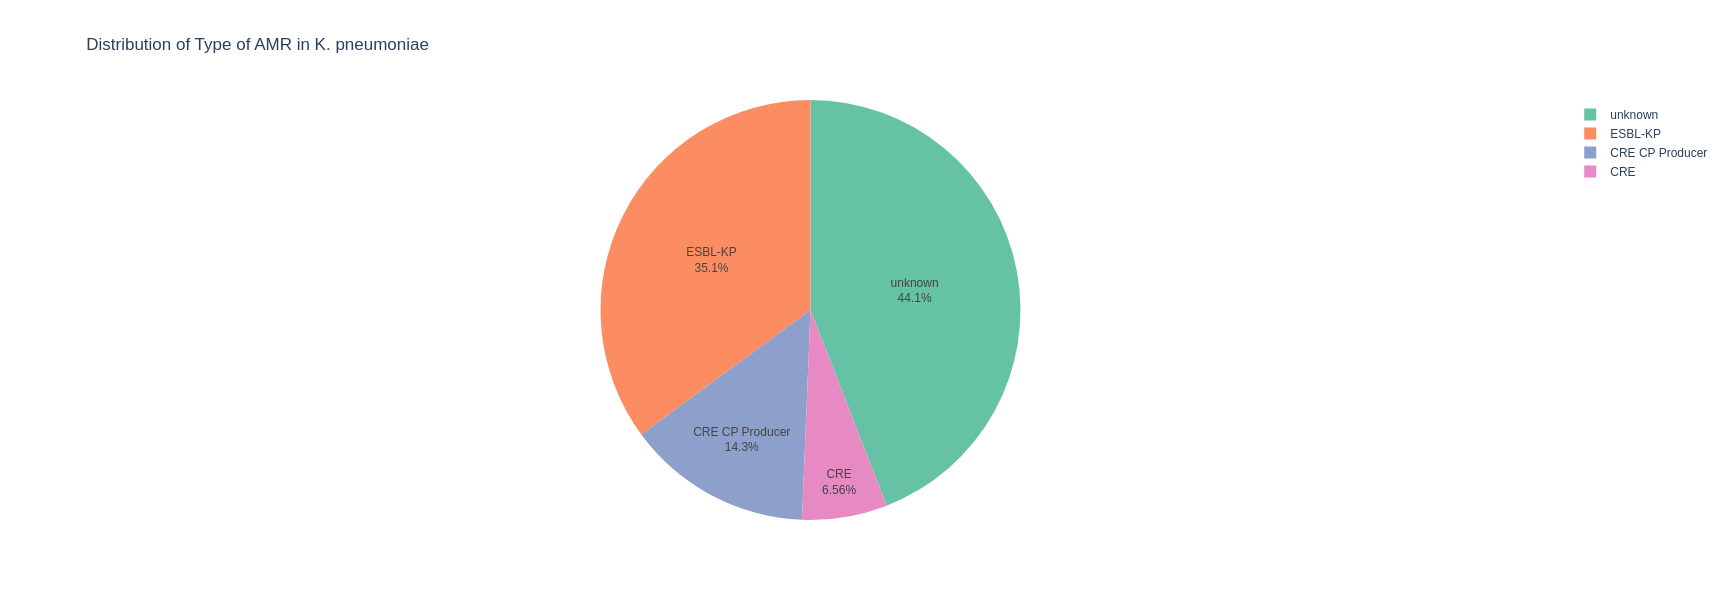

In [61]:
# Filter and prepare data
kp = df[df["Organism"] == "Klebsiella pneumoniae"].copy()
kp["Type of AMR"] = kp["Type of AMR"].fillna("unknown")

counts = kp["Type of AMR"].value_counts().reset_index()
counts.columns = ["Type of AMR", "Count"]

# Plotly pie chart
fig = px.pie(
    counts,
    names="Type of AMR",
    values="Count",
    title="Distribution of Type of AMR in K. pneumoniae",
    color_discrete_sequence=px.colors.qualitative.Set2,
    hole=0  # full pie chart
)

# Add percentage labels inside
fig.update_traces(textinfo="percent+label", textposition="inside")

fig.update_layout(
    height=600,
    showlegend=True
)

fig.show()

10. What percentage of Pseudomonas aeruginosa isolates are CR-PA?

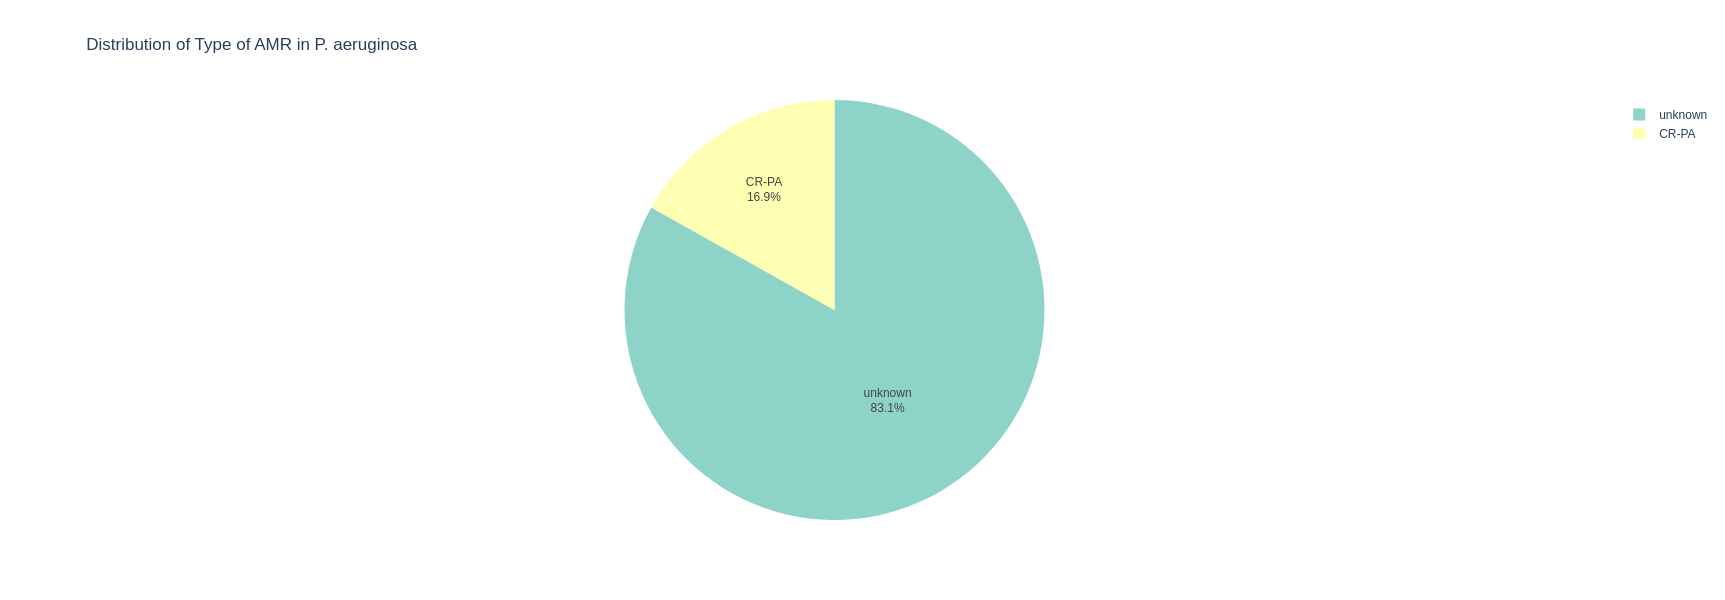

In [62]:
# Filter and prepare data
pa = df[df["Organism"] == "Pseudomonas aeruginosa"].copy()
pa["Type of AMR"] = pa["Type of AMR"].fillna("unknown")

counts = pa["Type of AMR"].value_counts().reset_index()
counts.columns = ["Type of AMR", "Count"]

# Plotly pie chart
fig = px.pie(
    counts,
    names="Type of AMR",
    values="Count",
    title="Distribution of Type of AMR in P. aeruginosa",
    color_discrete_sequence=px.colors.qualitative.Set3,
    hole=0  # full pie chart
)

# Add percentage labels inside
fig.update_traces(textinfo="percent+label", textposition="inside")

fig.update_layout(
    height=600,
    showlegend=True
)

fig.show()

11. What sample type contributes the most to ESBL-producing E. coli detection?

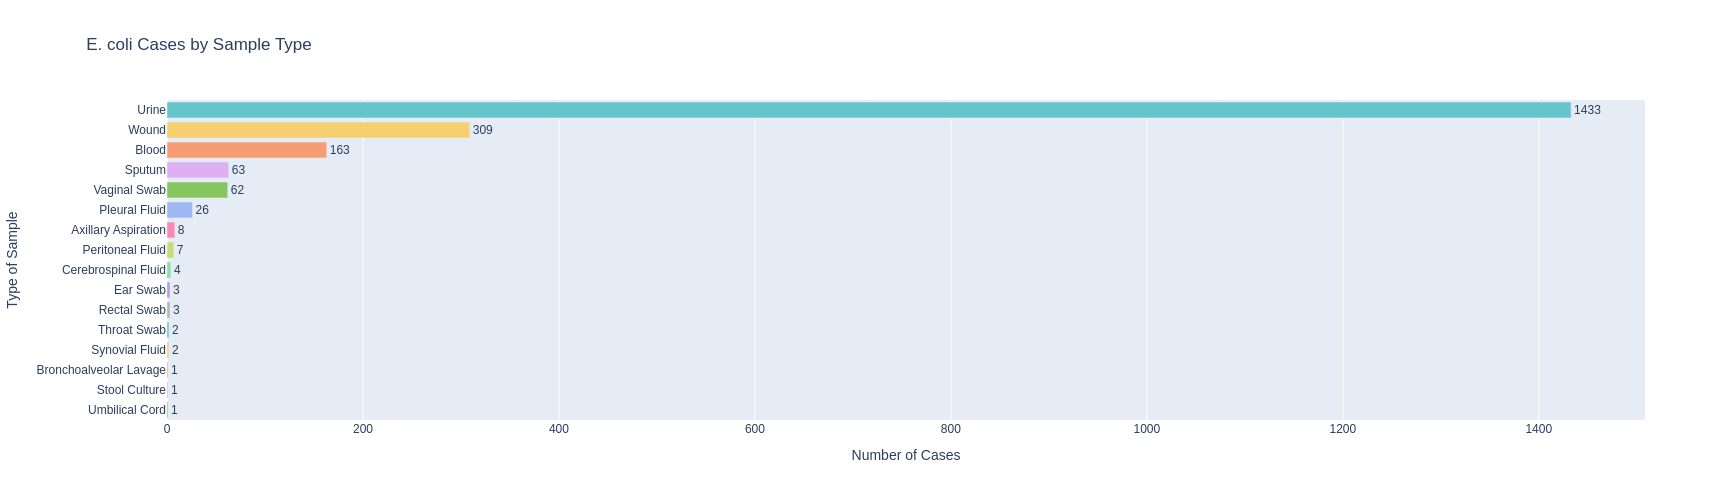

In [63]:
# Filter and prepare data
ecoli = df[df["Organism"] == "Escherichia coli"].copy()
ecoli["Type of AMR"] = ecoli["Type of AMR"].fillna("unknown")
ecoli = ecoli[ecoli["Type of AMR"] != "unknown"]

counts = ecoli["Type of Sample"].value_counts(ascending=False).reset_index()
counts.columns = ["Type of Sample", "Count"]

# Plotly bar chart (horizontal)
fig = px.bar(
    counts,
    x="Count",
    y="Type of Sample",
    orientation="h",
    title="E. coli Cases by Sample Type",
    text="Count",
    color="Type of Sample",
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    yaxis_title="Type of Sample",
    xaxis_title="Number of Cases",
    showlegend=False,
    height=500
)

fig.update_traces(textposition="outside")

fig.show()

12. Are there particular wards or patient groups with a higher prevalence of ESBL-producing organisms?

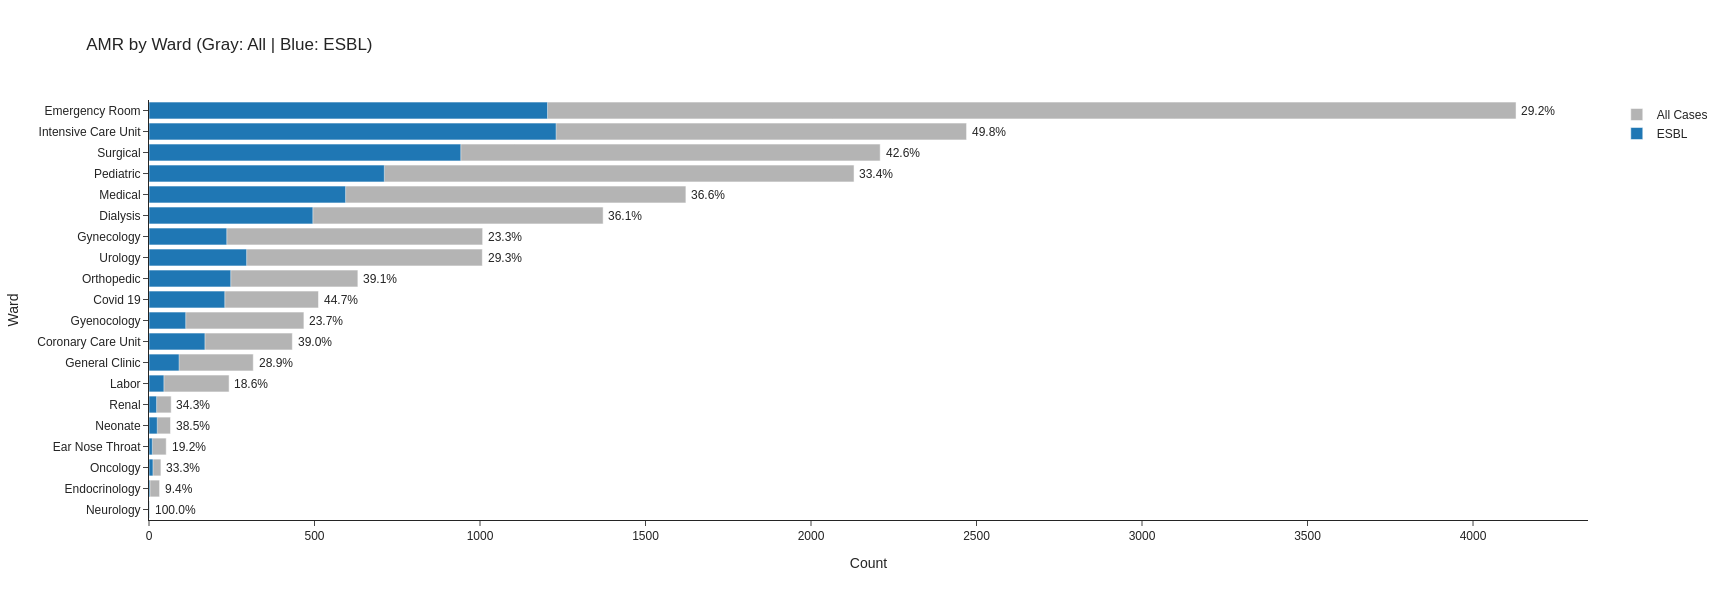

In [66]:
df2 = df.copy()
b1 = df2["Ward"].value_counts()

df2["Type of AMR"] = df2["Type of AMR"].fillna("unknown")
df2 = df2[df2["Type of AMR"] != "unknown"]
b2 = df2["Ward"].value_counts()

# Combine
b = pd.DataFrame([b1, b2]).T
b.columns = ["All", "ESBL"]
b.fillna(0, inplace=True)

# Ensure order by total counts
b = b.sort_values("All", ascending=True)
wards = b.index.tolist()

# Create stacked-style overlay bar plot
fig = go.Figure()

# Total (gray background bar)
fig.add_trace(go.Bar(
    y=wards,
    x=b["All"],
    name="All Cases",
    orientation='h',
    marker_color="#b4b4b4"
))

# ESBL (colored overlay bar)
fig.add_trace(go.Bar(
    y=wards,
    x=b["ESBL"],
    name="ESBL",
    orientation='h',
    marker_color="#1f77b4"
))

# Add percentage labels
for ward in wards:
    total = b.loc[ward, "All"]
    esbl = b.loc[ward, "ESBL"]
    if total > 0:
        pct = esbl / total * 100
        fig.add_annotation(
            x=total + 10,  # slightly after the total bar
            y=ward,
            text=f"{pct:.1f}%",
            showarrow=False,
            font=dict(size=12),
            xanchor="left"
        )

# Layout settings
fig.update_layout(
    barmode='overlay',
    title="AMR by Ward (Gray: All | Blue: ESBL)",
    xaxis_title="Count",
    yaxis_title="Ward",
    height=600,
    template="simple_white"
)

fig.show()

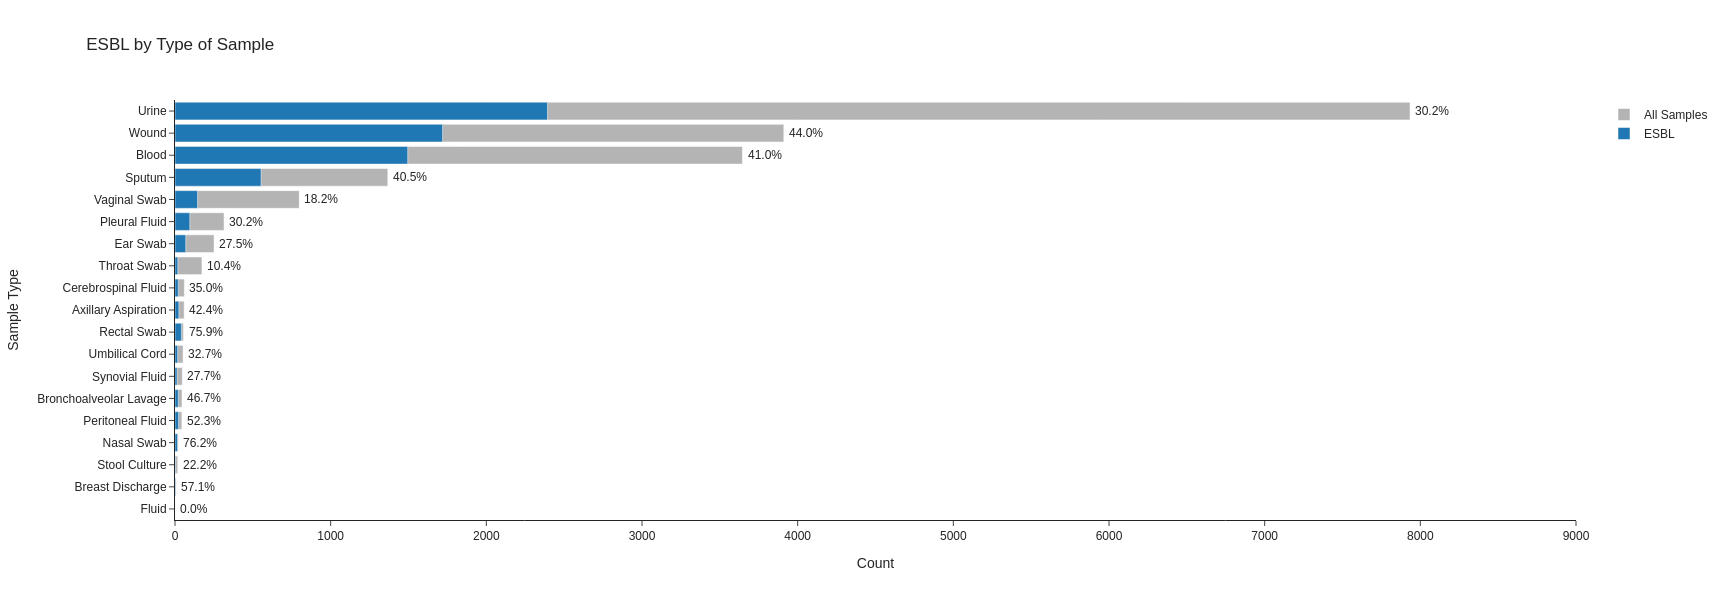

In [67]:
df2 = df.copy()
b1 = df2["Type of Sample"].value_counts()

df2["Type of AMR"] = df2["Type of AMR"].fillna("unknown")
df2 = df2[df2["Type of AMR"] != "unknown"]
b2 = df2["Type of Sample"].value_counts()

# Combine into one dataframe
b = pd.DataFrame([b1, b2]).T
b.columns = ["All", "ESBL"]
b.fillna(0, inplace=True)
b = b.sort_values("All", ascending=True)

sample_types = b.index.tolist()

fig = go.Figure()

# All cases bar (gray background)
fig.add_trace(go.Bar(
    y=sample_types,
    x=b["All"],
    name="All Samples",
    orientation='h',
    marker_color="#b4b4b4"
))

# ESBL cases bar (blue overlay)
fig.add_trace(go.Bar(
    y=sample_types,
    x=b["ESBL"],
    name="ESBL",
    orientation='h',
    marker_color="#1f77b4"
))

# Add % labels
for sample in sample_types:
    total = b.loc[sample, "All"]
    esbl = b.loc[sample, "ESBL"]
    if total > 0:
        pct = esbl / total * 100
        fig.add_annotation(
            x=total + 20,
            y=sample,
            text=f"{pct:.1f}%",
            showarrow=False,
            font=dict(size=12),
            xanchor="left"
        )

# Layout settings
fig.update_layout(
    barmode='overlay',
    title="ESBL by Type of Sample",
    xaxis_title="Count",
    yaxis_title="Sample Type",
    height=600,
    xaxis=dict(range=[0, 9000]),
    template="simple_white"
)

fig.show()

13. What are the trends in antibiotic resistance among E. coli, Klebsiella pneumoniae, Acinetobacter baumannii, and Staphylococcus aureus over the four years?

** maybe you want to check out these numbers first

In [68]:
def count_amr_in_species(species):
    counyer = df.loc[df["Organism"] == species, :]
    counyer.loc[:, "Type of AMR"] = counyer.loc[:, "Type of AMR"].fillna("unknown")

    e1 = {}

    for yr in range(2020, 2024):
        d = counyer.loc[counyer["Year"] == yr, :].groupby("Type of AMR").count()["ID"]
        e1[yr] = d

    return pd.DataFrame(e1)

Escherichia coli

In [69]:
count_amr_in_species("Escherichia coli")

,2020,2021,2022,2023
Type of AMR,,,,
CRE,2.0,7,6.0,5.0
CRE CP Producer,15.0,8,19.0,18.0
ESBL-EC,489.0,468,599.0,451.0
MRSE,NaN,1,NaN,NaN
unknown,748.0,800,872.0,1015.0


Klebsiella pneumoniae

In [70]:
count_amr_in_species("Klebsiella pneumoniae")

,2020,2021,2022,2023
Type of AMR,,,,
CRE,14,44,27,68
CRE CP Producer,46,48,135,104
ESBL-KP,173,285,230,131
unknown,174,232,268,355


Acinetobacter baumannii

In [71]:
count_amr_in_species("Acinetobacter baumannii")

,2020,2021,2022,2023
Type of AMR,,,,
CR-AB,72,90,132,53
unknown,18,15,16,11


Staphylococcus aureus

In [72]:
count_amr_in_species("Staphylococcus aureus")

,2020,2021,2022,2023
Type of AMR,,,,
MRSA,219.0,168,205.0,234.0
MRSE,NaN,3,NaN,NaN
unknown,201.0,217,162.0,165.0
